In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.callbacks import EarlyStopping
from collections import deque

In [3]:
df = pd.read_csv(r"C:\Users\Ehsan\Desktop\AI_project\voltage&current.csv" , delimiter=",")

In [5]:
df_filtered = df[(df['voltage'] >= 0) & (df['current']) >= 0]

In [7]:
SEQ_LEN = 20
VAL_RATIO = 0.05

In [9]:
box = deque(maxlen = SEQ_LEN)
boxes = []
data = df_filtered.values
for smp in data:
    box.append(((smp[0]) , (smp[1])))
    if len(box) == SEQ_LEN:
        boxes.append([np.array(box),smp[2]])

In [11]:
data_len = len(boxes)
val_len  = int(data_len * VAL_RATIO)

data_train = boxes[:-val_len]
data_val  = boxes[-val_len:]

In [13]:
x_t = []
x_v = []
y_t = []
y_v = []


for seq , target in data_train:
    x_t.append(seq)
    y_t.append(target)
    
for seq , target in data_val:
    x_v.append(seq)
    y_v.append(target)
    
    
x_training = np.array(x_t)
y_train = np.array(y_t)
x_valid    = np.array(x_v)
y_val    = np.array(y_v)    

In [15]:
scale = StandardScaler()

reshape_x_t = x_training.reshape(-1 , x_training.shape[-1])
reshape_x_v = x_valid.reshape(-1 , x_valid.shape[-1])

scale.fit(reshape_x_t)

scaled_x_t = scale.transform(reshape_x_t)
scaled_x_v = scale.transform(reshape_x_v)

x_train = scaled_x_t.reshape(x_training.shape)
x_val   = scaled_x_v.reshape(x_valid.shape)

In [17]:
cb = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
model = Sequential()

model.add(LSTM(128, input_shape=x_train.shape[1:], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

print(model.summary())

In [ ]:
results = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val) , callbacks=cb)

In [ ]:
model.save("model.h5")

In [ ]:
yhat_train = model.predict(x_train).round()
yhat_test  = model.predict(x_val).round()

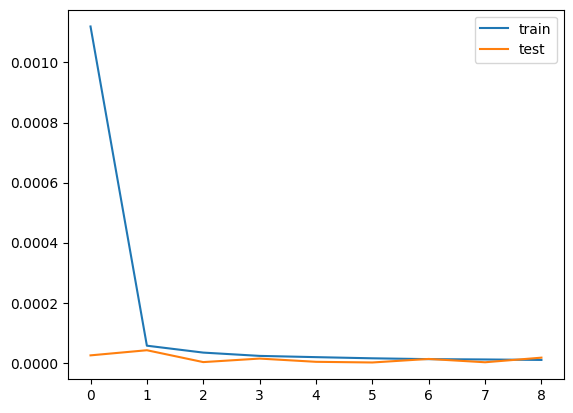

In [31]:
plt.plot(results.history["loss"] , label="train")
plt.plot(results.history["val_loss"] , label="test")
plt.legend()